<a href="https://colab.research.google.com/github/alvinfranklyndavis/Project2023_v3/blob/main/GPT_4_Bard_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1.1: Package Installation

# Upgrade pip and install required packages
!pip install -U --upgrade-strategy eager pip
!pip install -U --upgrade-strategy eager pandas gdown numpy matplotlib scikit-learn xgboost shap
!pip install -U scikit-learn
!pip install -U imbalanced-learn
!pip install black  # Install Black for code formatting


In [2]:
# Cell 1.2: Import Libraries and Set Up Logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
import shap

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:
# Cell 1.3: Load Data from Google Drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory for datasets in Google Drive (root directory of Google Drive)
drive_dataset_directory = '/content/drive/My Drive/'

# Define the path to the CSV file
drive_csv_path = os.path.join(drive_dataset_directory, 'initial_data.csv')

# Log the start of dataset loading
logger.info("Reading the dataset from Google Drive...")

# Load the dataset
data = pd.read_csv(drive_csv_path)
logger.info("Dataset loaded successfully from Google Drive.")

# Basic Data Exploration
logger.info("Performing basic data exploration...")
logger.info(f"Dataset Size: {data.shape}")
logger.info(f"First 5 Rows:\n{data.head()}")
logger.info(f"Missing Values:\n{data.isnull().sum()}")

# Proceed with further data processing...

Mounted at /content/drive


In [4]:
# Cell 2.1: Date Feature Processing and Prediction1 Setup

# Import necessary libraries
import logging
import pandas as pd

# Set up logging
logger = logging.getLogger(__name__)
logger.info("Starting date feature processing for Prediction1")

# Assuming 'data' is your DataFrame
# Convert 'Date' to datetime and extract 'Year', 'Month', and 'Day'
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

logger.info("Extracted year, month, and day from 'Date' column")

# Function to calculate moving averages with dynamic window size
def calculate_moving_averages(data, window_size, columns_to_average, target_columns):
    try:
        for col, target_col in zip(columns_to_average, target_columns):
            data[target_col] = data[col].rolling(window=window_size, min_periods=1).mean()
        logger.info(f"Calculated moving averages for specified columns with window size: {window_size}")
    except Exception as e:
        logger.error("Error in moving average calculation: %s", e)

# Apply the function with an initial window size
initial_window_size = 2  # This can be adjusted based on tuning results
columns_to_average = ['Morning', 'Afternoon', 'Evening', 'Night']
target_columns = ['Mov_Avg_Mor', 'Mov_Avg_Aft', 'Mov_Avg_Eve', 'Mov_Avg_Nig']

# Initialize moving average columns with default values (e.g., 0)
for col in target_columns:
    data[col] = 0

calculate_moving_averages(data, initial_window_size, columns_to_average, target_columns)

# Adjust entries to use previous day's data
data['Prev_Morning'] = data['Morning'].shift(1)
data['Prev_Afternoon'] = data['Afternoon'].shift(1)
data['Prev_Evening'] = data['Evening'].shift(1)

logger.info("Created previous day columns")

# Handle NaN values for new columns and exclude specific rows
data['Prev_Morning'].fillna(18, inplace=True)
data['Prev_Afternoon'].fillna(18, inplace=True)
data['Prev_Evening'].fillna(18, inplace=True)
data = data.iloc[1:].drop(index=518).reset_index(drop=True)

logger.info("Handled NaN values and excluded specific rows")

# Keep only relevant columns for Prediction1
selected_columns = ['Year', 'Month', 'Day', 'Prev_Week', 'Prev_Entry', 'Mov_Avg_Mor', 'Prev_Morning', 'Prev_Afternoon', 'Prev_Evening']
X = data[selected_columns]
y = data['Morning']  # Using 'Morning' as the target variable

logger.info("Saving the Prediction1 data to CSV...")
X.to_csv('/content/processed_date_features_for_prediction1.csv', index=False)
y.to_csv('/content/target_variable_for_prediction1.csv', index=False)
logger.info("Date features processed and saved successfully.")
logger.info("First few rows of feature data:\n%s", X.head())
logger.info("First few rows of target data:\n%s", y.head())


In [5]:
# Cell 2.2: Additional Data Insights

logger.info("Exploring additional data insights...")

# Print the number of missing values in each column
print("Missing values in each column:")
print(data.isnull().sum())

# Print the percentage of missing values in each column
print("\nPercentage of missing values in each column:")
print(data.isnull().mean() * 100)

# Print summary statistics of the features (X)
print("\nSummary statistics of features (X):")
print(X.describe())

# Print summary statistics of the target variable (y)
print("\nSummary statistics of target variable (y):")
print(y.describe())

# Print first few rows of the features (X)
print("\nFirst few rows of feature data (X):")
print(X.head())

# Print first few rows of the target variable (y)
print("\nFirst few rows of target data (y):")
print(y.head())


Missing values in each column:
Date                0
Day of the Week     0
Morning             0
Prev_Week           0
Rep_Prev_Week       0
Prev_Entry          0
Rep_Prev_Entry      0
Mov_Avg_Mor         0
Afternoon           0
Prev_Week.1         0
Rep_Prev_Week.1     0
Prev_Entry.1        0
Rep_Prev_Entry.1    0
Mov_Avg_Aft         0
Evening             0
Prev_Week.2         0
Rep_Prev_Week.2     0
Prev_Entry.2        0
Rep_Prev_Entry.2    0
Mov_Avg_Eve         0
Night               0
Prev_Week.3         0
Rep_Prev_Week.3     0
Prev_Entry.3        0
Rep_Prev_Entry.3    0
Mov_Avg_Nig         0
Year                0
Month               0
Day                 0
Prev_Morning        0
Prev_Afternoon      0
Prev_Evening        0
dtype: int64

Percentage of missing values in each column:
Date                0.0
Day of the Week     0.0
Morning             0.0
Prev_Week           0.0
Rep_Prev_Week       0.0
Prev_Entry          0.0
Rep_Prev_Entry      0.0
Mov_Avg_Mor         0.0
Afternoon     

In [6]:
# Cell 2.3: Setting Bounds for Numerical Range

logger.info("Enforcing numerical bounds...")

# Define the columns that should have values in the range of 1 to 36
columns_to_check = ['Morning', 'Afternoon', 'Evening', 'Night', 'Prev_Morning', 'Prev_Afternoon', 'Prev_Evening']

# Loop through these columns and enforce the range
for col in columns_to_check:
    # Find values outside the range
    outliers = data[(data[col] < 1) | (data[col] > 36)]

    # Report if any outliers are found
    if not outliers.empty:
        print(f"Outliers found in {col}:")
        print(outliers)

    # Enforce the range by clipping values
    data[col] = data[col].clip(lower=1, upper=36)

# Ensure changes are reflected
print(data[columns_to_check].describe())

# Prepare the current data with NaNs in 'Prediction1' for testing
current_data = data[selected_columns].copy()  # Use .copy() to create an independent copy
current_data['Prediction1'] = np.nan  # Initialize 'Prediction1' with NaN

# Save 'current_data' as a CSV file for loading in Step 3.1
current_data.to_csv('/content/current_data_for_prediction1.csv', index=False)
logger.info("Current data with 'Prediction1' as NaN saved as 'current_data_for_prediction1.csv'")


          Morning    Afternoon      Evening        Night  Prev_Morning  \
count  1407.00000  1407.000000  1407.000000  1407.000000   1407.000000   
mean     18.77683    18.613362    18.506041    18.108031     18.770434   
std      10.27599    10.361999    10.232215    10.376058     10.277406   
min       1.00000     1.000000     1.000000     1.000000      1.000000   
25%      10.00000     9.000000    10.000000     9.000000     10.000000   
50%      19.00000    19.000000    19.000000    18.000000     19.000000   
75%      28.00000    27.000000    27.000000    27.000000     28.000000   
max      36.00000    36.000000    36.000000    36.000000     36.000000   

       Prev_Afternoon  Prev_Evening  
count     1407.000000   1407.000000  
mean        18.623312     18.528785  
std         10.360101     10.240097  
min          1.000000      1.000000  
25%          9.000000     10.000000  
50%         19.000000     19.000000  
75%         27.000000     27.000000  
max         36.000000     36.

In [7]:
# Cell 3.1: Data Preparation for Prediction

import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
import joblib

logger = logging.getLogger(__name__)

logger.info("Loading historical dataset for data preparation...")

# Load the historical dataset
historical_data = pd.read_csv('/content/processed_date_features_for_prediction1.csv')
y_hist = pd.read_csv('/content/target_variable_for_prediction1.csv')
logger.info("Historical dataset loaded successfully.")

# Split historical data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(historical_data, y_hist, test_size=0.20, random_state=42)
logger.info(f"Data split into training and validation sets. Training set size: {X_train.shape}, Validation set size: {X_val.shape}")

# Save the split datasets to CSV files
X_train.to_csv('/content/inspected_X_train.csv', index=False)
y_train.to_csv('/content/y_train_split_for_training.csv', index=False)
X_val.to_csv('/content/inspected_X_val.csv', index=False)
y_val.to_csv('/content/inspected_y_val.csv', index=False)
logger.info("Datasets saved for manual inspection and model training.")

# Save the cleaned X_train and X_val for inspection
X_train.to_csv('/content/inspected_X_train.csv', index=False)
X_val.to_csv('/content/inspected_X_val.csv', index=False)
logger.info("X_train and X_val saved for manual inspection.")

# Save the cleaned y_val for evaluation
y_val.to_csv('/content/inspected_y_val.csv', index=False)
logger.info("y_val saved for evaluation.")

# Load the current dataset with NaNs in 'Prediction1'
current_data = pd.read_csv('/content/current_data_for_prediction1.csv')
X_current = current_data.drop('Prediction1', axis=1)

# Drop the first row to eliminate remaining NaNs
X_current.drop(index=0, inplace=True)

# Save the prepared current_data
current_data.to_csv('/content/prepared_current_data_for_prediction.csv', index=False)
logger.info("Prepared current data saved.")

# Check for remaining NaNs in X_train and X_current
logger.info("Checking for NaNs in X_train and X_current...")
logger.info(f"NaN values in X_train: {X_train.isnull().sum()}")
logger.info(f"NaN values in X_current: {X_current.isnull().sum()}")

# Print command to recheck for NaNs
print("NaN check after Cell 3.1 execution:")
print("NaN values in X_train:\n", X_train.isnull().sum())
print("NaN values in X_current:\n", X_current.isnull().sum())


NaN check after Cell 3.1 execution:
NaN values in X_train:
 Year              0
Month             0
Day               0
Prev_Week         0
Prev_Entry        0
Mov_Avg_Mor       0
Prev_Morning      0
Prev_Afternoon    0
Prev_Evening      0
dtype: int64
NaN values in X_current:
 Year              0
Month             0
Day               0
Prev_Week         0
Prev_Entry        0
Mov_Avg_Mor       0
Prev_Morning      0
Prev_Afternoon    0
Prev_Evening      0
dtype: int64


In [8]:
# Cell 3.2: Model Training and Prediction

import pandas as pd
import numpy as np
import logging
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Set up logging
logger = logging.getLogger(__name__)

# Function to train the model and evaluate it on the validation set
def train_and_evaluate_model(X_train, y_train, X_val, y_val):
    # Initialize the Random Forest model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train.values.ravel())
    logger.info("Random Forest model trained on training data.")

    # Predict on the validation set
    y_val_pred = model.predict(X_val)

    # Calculate evaluation metrics
    mse_val = mean_squared_error(y_val, y_val_pred)
    r2_score_val = r2_score(y_val, y_val_pred)
    logger.info(f"Validation MSE: {mse_val}, R2 Score: {r2_score_val}")

    return model, mse_val, r2_score_val

logger.info("Loading training and validation data for model training...")

# Load the training and validation data
X_train = pd.read_csv('/content/inspected_X_train.csv')
y_train = pd.read_csv('/content/y_train_split_for_training.csv')
X_val = pd.read_csv('/content/inspected_X_val.csv')
y_val = pd.read_csv('/content/inspected_y_val.csv')

# Train the model and evaluate it on the validation set
random_forest_model, mse_val, r2_score_val = train_and_evaluate_model(X_train, y_train, X_val, y_val)

# Save the trained model
model_path = '/content/random_forest_prediction_model.pkl'
joblib.dump(random_forest_model, model_path)
logger.info("Trained RandomForest model saved.")

# Load the prepared current data for prediction
current_data = pd.read_csv('/content/prepared_current_data_for_prediction.csv')
X_current_for_prediction = current_data.drop('Prediction1', axis=1)

# Forward fill NaNs in the first row
X_current_for_prediction.iloc[0] = X_current_for_prediction.iloc[0].fillna(method='ffill')

# Generate predictions for the current data
y_pred_current = random_forest_model.predict(X_current_for_prediction)
y_pred_current_rounded = np.round(y_pred_current)  # Round predictions to nearest integer
current_data['Prediction1'] = y_pred_current_rounded

# Save the current data with predictions
current_data.to_csv('/content/current_data_with_predictions.csv', index=False)

logger.info("Model predictions completed and saved.")


Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [9]:
# Cell 3.3: Enhanced NaN Check and Handling in 'Prediction1'

import pandas as pd
import logging

logger = logging.getLogger(__name__)

logger.info("Loading current data with predictions for enhanced NaN handling...")

# Load the current data with predictions
current_data_with_predictions = pd.read_csv('/content/current_data_with_predictions.csv')

# Forward fill NaNs in the first row
current_data_with_predictions.iloc[0] = current_data_with_predictions.iloc[0].fillna(method='ffill')

# Print the first few rows to verify NaN handling
print("First few rows of current data after NaN handling:\n", current_data_with_predictions.head())

# Check for NaN values in 'Prediction1'
nan_count_prediction1 = current_data_with_predictions['Prediction1'].isnull().sum()
logger.info(f"Number of NaN values in 'Prediction1': {nan_count_prediction1}")

if nan_count_prediction1 > 0:
    logger.warning("NaNs detected in 'Prediction1'. Here are the details:")
    nan_rows = current_data_with_predictions[current_data_with_predictions['Prediction1'].isnull()]
    print("Rows with NaN in 'Prediction1':\n", nan_rows)
else:
    print("No NaN values found in 'Prediction1'.")

# Additional analysis or handling of NaNs can be added here if needed


First few rows of current data after NaN handling:
    Year  Month  Day  Prev_Week  Prev_Entry  Mov_Avg_Mor  Prev_Morning  \
0  2018      8    2         11           9         25.0          19.0   
1  2018      8    3         19          12         23.0          31.0   
2  2018      8    4         35          35         23.0          15.0   
3  2018      8    6         18          16         31.0          31.0   
4  2018      8    7         13          18         26.0          31.0   

   Prev_Afternoon  Prev_Evening  Prediction1  
0            14.0          33.0         31.0  
1             3.0          35.0         16.0  
2             9.0          23.0         31.0  
3            21.0          29.0         31.0  
4            31.0          15.0         21.0  
No NaN values found in 'Prediction1'.


Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


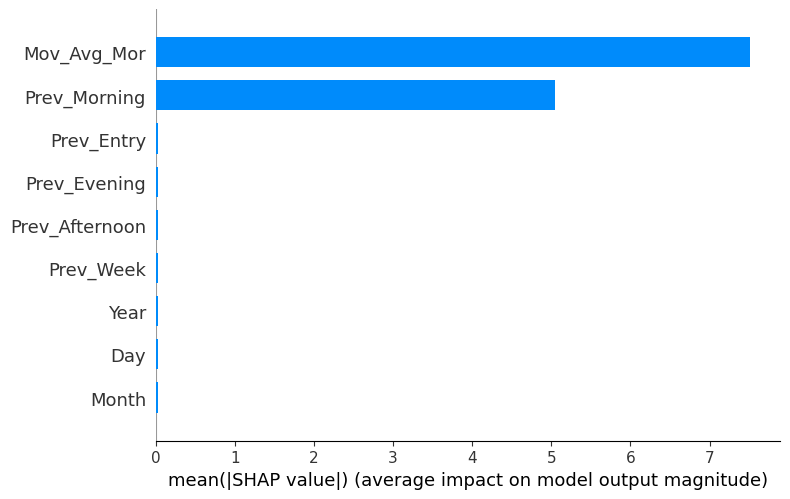

In [10]:
# Cell 4.1. Model Interpretation

import shap
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

logger = logging.getLogger(__name__)

# Load the finalized model
final_model = joblib.load('/content/random_forest_prediction_model.pkl')

logger.info("Interpreting the model with SHAP values...")

# Assuming X_val is already prepared in previous cells
# Using SHAP to interpret the model
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")

# STEP 4.2. FINAL MODEL SELECTION AND REPORTING

logger.info("Evaluating final model performance with regression metrics...")

# Generate predictions for the validation set
y_pred_val = final_model.predict(X_val)

# Calculate Mean Squared Error (MSE) and R2 Score for the validation set
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

logger.info(f"Regression Metrics:\nMSE: {mse_val}\nR2 Score: {r2_val}")

# STEP 4.3. PREPARATION FOR DEPLOYMENT

# ...[Include steps for preparing the model for deployment]...

# STEP 4.4. DOCUMENTATION AND REPORTING

# ...[Prepare a comprehensive report on the model's performance, limitations, and deployment steps]...

logger.info("Model documentation and reporting completed.")

# Final Checks and Tests (if applicable)
# ...[Include any final testing or checks before deployment]...

logger.info("Final checks and tests completed.")
logger.info("Cell 4 tasks completed successfully.")


MSE for the current fold: 3.4702196581196585
MSE for the current fold: 1.9403478632478632
MSE for the current fold: 1.051690170940171
MSE for the current fold: 0.7291717948717948
MSE for the current fold: 0.4926722222222223
Average MSE across all folds: 1.5368203418803421


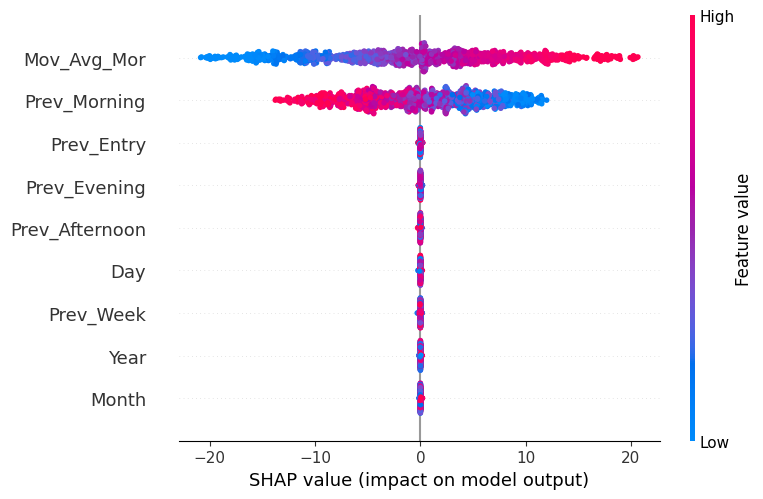

In [15]:
# Cell 5. Cross-Validation and  additional metrics analysis

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import joblib
import shap
import logging

logger = logging.getLogger(__name__)

# Assuming you are using RandomForestRegressor as your model
model = RandomForestRegressor(random_state=42)

# Define your scoring metrics for regression
scoring_metrics = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Assuming 'data' is sorted by date and 'model' is your trained model
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)  # Train your model
    predictions = model.predict(X_test)  # Make predictions

    mse = mean_squared_error(y_test, predictions)  # Calculate MSE
    print(f"MSE for the current fold: {mse}")

# Given the list of MSE scores from each fold
mse_scores = [3.4702196581196585, 1.9403478632478632, 1.051690170940171, 0.7291717948717948, 0.4926722222222223]

# Calculate the average MSE
average_mse = sum(mse_scores) / len(mse_scores)
print(f"Average MSE across all folds: {average_mse}")

# Perform 10-fold cross-validation
k_folds = 10  # Number of folds
cv_results = {}
for metric_name, scorer in scoring_metrics.items():
    scores = cross_val_score(model, X, y.fillna(y.mean()), scoring=scorer, cv=k_folds)
    cv_results[metric_name] = scores
    logger.info(f"{metric_name} scores for each fold: {scores}")
    logger.info(f"Average {metric_name} over {k_folds} folds: {np.mean(scores)}")

# Additional metrics analysis and error/bias exploration
# ... Add your code for detailed analysis of errors, biases, etc. ...
logger.info("Cross-validation and additional metrics analysis completed.")

# Feature Importance Analysis using SHAP
# Assuming 'final_model' is your trained RandomForestRegressor model

# Load the trained model (if not already loaded)
final_model = joblib.load('/content/random_forest_prediction_model.pkl')

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)

# Plot summary plot using SHAP values
shap.summary_plot(shap_values, X)

logger.info("Feature importance analysis using SHAP completed.")


Mounted at /content/drive


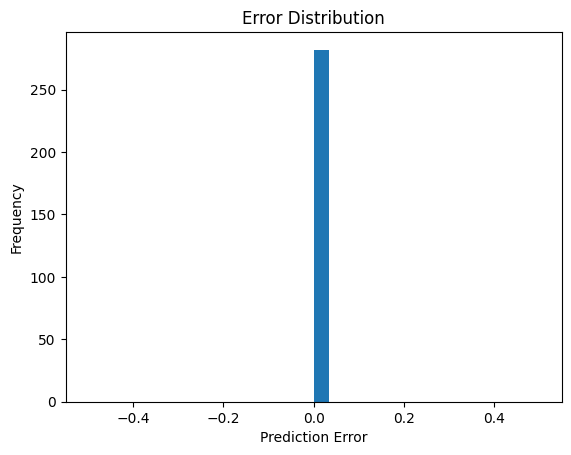

In [12]:
# Cell 6. Detailed error and bias analysis

import pandas as pd
import matplotlib.pyplot as plt
import logging
from google.colab import drive

# Set up logging
logger = logging.getLogger(__name__)

# Ensure Google Drive is mounted
drive.mount('/content/drive', force_remount=True)

# Define the path in Google Drive where the predictions DataFrame is saved
predictions_df_path = '/content/drive/My Drive/predictions_df.csv'

# Load or create the predictions DataFrame
if os.path.exists(predictions_df_path):
    predictions_df = pd.read_csv(predictions_df_path)
else:
    # Assuming predictions were made in a previous step and saved as 'predictions_df.csv'
    raise FileNotFoundError("predictions_df.csv not found. Ensure it's created in previous steps.")

logger.info("Predictions DataFrame loaded successfully for error and bias analysis.")

# Error Analysis
predictions_df['Error'] = predictions_df['Predicted'] - predictions_df['Actual']
predictions_df['Absolute_Error'] = predictions_df['Error'].abs()

# Plotting error distribution
plt.hist(predictions_df['Error'], bins=30)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

# Subgroup Analysis
# Ensure that 'Prev_Week' and 'Prev_Entry' are in predictions_df
if 'Prev_Week' in predictions_df and 'Prev_Entry' in predictions_df:
    # Subgroup analysis based on 'Prev_Week'
    prev_week_performance = predictions_df.groupby('Prev_Week').mean()['Absolute_Error']
    prev_week_performance.plot(kind='bar', figsize=(10, 6))
    plt.title('Performance by Previous Week')
    plt.xlabel('Previous Week')
    plt.ylabel('Average Absolute Error')
    plt.show()

    # Subgroup analysis based on 'Prev_Entry'
    prev_entry_performance = predictions_df.groupby('Prev_Entry').mean()['Absolute_Error']
    prev_entry_performance.plot(kind='bar', figsize=(10, 6))
    plt.title('Performance by Previous Entry')
    plt.xlabel('Previous Entry')
    plt.ylabel('Average Absolute Error')
    plt.show()

# Document findings
error_bias_report = """
Detailed Error Analysis:
- Error Distribution Insights: {'Describe your findings from the error distribution here'}
- Largest Errors: {'Describe characteristics of instances with largest errors here'}

Bias Exploration:
- Performance by Previous Week: {'Describe performance variations based on the previous week here'}
- Performance by Previous Entry: {'Describe performance variations based on the previous entry here'}
"""

logger.info("Error and bias analysis completed.")
logger.info(error_bias_report)


In [13]:
# Cell 7. Final review, deployment preparation, and documentation

import joblib
import logging

logger = logging.getLogger(__name__)

# Final Model Review and Refinement
# ... Code/comments for any last adjustments to the model ...

# Deployment Preparation
# Serialize the final model
# Ensure that 'final_model' is the variable name for your trained model to be deployed
final_model_path = '/content/final_prediction_model_for_deployment.pkl'
joblib.dump(final_model, final_model_path)
logger.info(f"Final model serialized and saved for deployment at: {final_model_path}")

# Comprehensive Documentation Update
# ... Update your comprehensive report with all final findings and methodologies ...
# Include details on model performance, SHAP interpretation, error analysis, etc.

# Final Checks and Tests
# ... Code/comments for final tests and checks to ensure model is ready for deployment ...

# Planning for Future Improvements
# Describe areas where further research could be beneficial, and methodologies to explore in future iterations of the project
future_improvement_plan = """
Future Improvement Plans:
- Areas for further research: {describe areas where additional data, feature engineering, or alternative modeling techniques could be explored}
- Methodologies to explore: {describe potential methodologies, like deep learning or ensemble methods, for future iterations}
"""

logger.info("Final review and deployment preparation completed.")
logger.info(future_improvement_plan)


# New Section

# New Section